# Collaborative Filtering with Surprise

This notebook uses the Surprise library for user-user and item-item collaborative filtering.

In [214]:
# Import standard libraries
import numpy as np
import math
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from collections import Counter
from time import sleep
from collections import defaultdict

# Import packages from Surprise
from surprise import KNNBasic, KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

# # Import sklearn packages
# from sklearn.metrics import confusion_matrix, pairwise_distances, mean_squared_error
# from sklearn import metrics

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


### Functions

In [215]:
def train_test_convert(train_df, test_df):
    '''
    Function that converts train and test dataframes into
    train and test objects that Surpise can read.
    
    Arguments:
    - train_df  :  train dataframe ("customer_id", "product_title", "star_rating") 
    - test_df   :  test dataframe ("customer_id", "product_title", "star_rating")
    
    Returns:
    - trainset  :  train_df as trainset object
    - testset   :  test_df as list of tuples
    '''
    # Convert train
    # A reader is still needed but only the rating_scale param is requiered.
    reader = Reader(rating_scale=(1, 5))
    # The columns must correspond to user id, item id and ratings (in that order).
    data = Dataset.load_from_df(train_df[['customer_id', 'product_title', 'star_rating']], reader)
    trainset = data.build_full_trainset()
    
    # Convert test
    test_df['star_rating'] = test_df['star_rating'].astype('float64')
    testset = [tuple(x) for x in test_df.values]
    
    return trainset, testset
    

In [216]:
def plot_rmse(k_range, trainset, testset, algorithm='KNNWithMeans', sim_options={}):
    '''
    Function which takes in a range of K nearest neighbors values.
    Calculates the RMSE on train and test for each K and plots this.
    
    Arguments:
    - k_range    :  range of k-nearest-neighbors to try
    - trainset   :  trainset as trainset object
    - testset    :  testset as list of tuples
    - algorithm  :  type of algorithm
    
    Returns:
    - scores_df  :  dataframe of rmse at each k
    '''
    
    scores_dict = {'k': [], 'test_rmse': []}
    
    for k in k_range:
        if algorithm == 'KNNBasic':
            algo = KNNBasic(k=k, sim_options=sim_options, verbose=False)
        elif algorithm == 'KNNWithMeans':
            algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
        elif algorithm == 'KNNBaseline':
            algo = KNNBaseline(k=k, sim_options=sim_options, verbose=False)
        elif algorithm == 'KNNWithZScore':
            algo = KNNWithZScore(k=k, sim_options=sim_options, verbose=False)
            
        algo.fit(trainset)

        test_pred = algo.test(testset)
        test_rmse = accuracy.rmse(test_pred, verbose=False)
        
        scores_dict['k'].append(k)
        scores_dict['test_rmse'].append(test_rmse)
    
    scores_df = pd.DataFrame(scores_dict)
    
    plt.figure(figsize=(10,7));
    plt.plot(scores_df['k'], scores_df['test_rmse']);
    plt.title('RMSE for Different Values of K', fontsize=15);
    plt.xlabel('K');
    plt.ylabel('RMSE');
    
    return scores_df
        

In [217]:
def get_n_recommendations(predictions, n=15):
    '''
    Return the top-n recommendations for each user from a set of predictions.

    Arguments:
    - predictions  :  list of prediction objects, returned by the algorithm (algo).
    - n            :  Number of recommendations to output for each user.

    Returns:
    - top_n        :  A dictionary where keys are user ids and values are lists of tuples of size n.
    '''
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [218]:
def print_customer_prof(train_df, test_df, top_n, customer=13516428):
    '''
    Function which looks at an example of a user's ratings and recommendations made
    
    Arguments:
    - customer  :  customer id
    - train_df  :  train dataframe
    - test_df   :  test dataframe
    - top_n     :  dictionary of predictions 
    
    Prints:
    - customer's pre-2014 ratings
    - customer's post-2014 ratings
    - recommendations
    '''

    print('Pre-2014 selections (customer id - {}):'.format(customer))
    print(train_df[train_df['customer_id']==customer][['product_title','star_rating']])
    
    print('\nPost-2014 selections (customer id - {}):'.format(customer))
    print(test_df[test_df['customer_id']==customer][['product_title','star_rating']])
    
    print('\nRecommendations:')
    for i in top_n[customer]:
        print(i[0])

### Evaluation Functions

**Precision:** A score of how many recommendations were relevant to a user.

$${\large \qquad Precision = \frac{\textrm{# of our recommendations that are relevant}}{\textrm{# of items we recommended}} }$$

<br>

**Average Precision:** The average of a recommender system's precision scores up to a certain cutt-off number of recommendations for a particular user.

$$\textrm{AP@N} = \frac{1}{m}\sum_{k=1}^N \textrm{($P(k)$ if $k^{th}$ item was relevant)} = \frac{1}{m}\sum_{k=1}^N P(k)\cdot rel(k)$$

<br>

**Mean Average Precision (MAP):** The mean of all the average precision scores across all users.

$$\textrm{MAP@N} = \frac{1}{|U|}\sum_{u=1}^|U|(\textrm{AP@N})_u = \frac{1}{|U|} \sum_{u=1}^|U| \frac{1}{m}\sum_{k=1}^N P_u(k)\cdot rel_u(k)$$

<br>

In [219]:
def evaluate_precision(top_n_recs, testset, threshold=4.0):
    '''
    Function which calculates the average recall score of the test set.
    Recall here is defined as the number of recommendations the user actually liked in the test set.
    
    Arguments:
    - top_n_recs  :  dictionary of top N predictions for all users
    - testset     :  test_df as list of tuples 
    - threshold   :  what is considered a like by a customer
    
    Returns:
    - ave_recall  :  average recall score across all test users
    '''
    
    # Convert testset into dictionary with user as key and items they rated as values
    test_dict = defaultdict(list)
    for uid, iid, r in testset:
        test_dict[uid].append((iid, r))
    
    hit_list = []
    for user, ratings in test_dict.items():

        actual_liked = [i for i, r in ratings if r >= threshold]
        preds = [i[0] for i in top_n_recs[user]]

        hits = (set(actual_liked) & set(preds))

        hit_rate = len(hits)/len(preds)
        hit_list.append(hit_rate)
    
    ave_recall = np.mean(hit_list)
    
    return ave_recall

In [220]:
def evaluate_map(top_n_recs, testset, threshold=4.0):
    '''
    Function which calculates the mean average precision (MAP) for each user and returns the mean of these values
    
    Arguments:
    - top_n_recs  :  dictionary of top N predictions for all users
    - testset     :  test_df as list of tuples 
    - threshold   :  what is considered a like by a customer
    
    Returns:
    - mean_map  :  mean MAP across all users
    '''
    
    # Convert testset into dictionary with user as key and items they rated as values
    test_dict = defaultdict(list)
    for uid, iid, r in testset:
        test_dict[uid].append((iid, r))
    
    aps = []
    for user, ratings in test_dict.items():

        actual_liked = [i for i, r in ratings if r >= threshold]
        recommendations = [i[0] for i in top_n_recs[user]]
        
        precisions = []
        recalls = []
        for i, rec in enumerate(recommendations):
            
            hits = (set(actual_liked) & set(recommendations[:i+1]))
            prec = len(hits)/(i+1)
            
            if len(hits) >= 1:
                change_recall = 1/len(actual_liked)
            else:
                change_recall = 0
            
            precisions.append(prec)
            recalls.append(change_recall)

        ap = np.sum([prec * chg_rec for prec, chg_rec in zip(precisions, recalls)])
        aps.append(ap)
    
    mean_map = np.mean(aps)
    
    return mean_map

In [314]:
def new_recommendations(new_products, orig_data, algo):
    '''
    Function that takes in a list of new products and returns recommendations.
    
    Arguments:
    - new_products   :  list of products chosen by new user
    - orig_data      :  original dataframe of users, items and ratings
    
    Returns:
    - recs_df        :  dataframe of recommendations
    '''
    # Append new customer to data
    new_data = pd.DataFrame({'customer_id':[1]*len(new_products), 
                             'product_title':new_products, 
                             'star_rating':[5]*len(new_products)})
    full_data = pd.concat([new_data, orig_data]).reset_index(drop=True)
    
    # A reader is still needed but only the rating_scale param is requiered.
    reader = Reader(rating_scale=(1, 5))

    # The columns must correspond to user id, item id and ratings (in that order)
    data = Dataset.load_from_df(full_data[['customer_id', 'product_title', 'star_rating']], reader)
    
    # Convert to surprise.trainset.Trainset object
    trainset = data.build_full_trainset()
    
    # Train model
    algo.fit(trainset)
    
    # Recommendations dictionary to convert into datframe
    recommendations = {'items': [], 'rating': []}
    items = [trainset.to_raw_iid(i) for i in trainset.all_items()]
    for item in items:
        rating = algo.predict(1, item, verbose=True)[3]
        recommendations['items'].append(item)
        recommendations['rating'].append(rating)
    
    recs_df = pd.DataFrame(recommendations).sort_values(by='rating', ascending=False)
    
    return recs_df

In [222]:
def scores_df(scores):
    '''
    Function which takes in a list of models and returns a dataframe of the models and their scores.
    
    Arguments:
    - scores   :  list of models and their scores
    
    Returns:
    - df       :  dataframe of models and their scores
    '''
    scores_dict = {'Model': [],
                  'RMSE': [],
                  'Unranked Precision': [],
                  'MAP': []}
    
    for score in scores:
        # Update dictionary with model and results
        scores_dict['Model'].append(score['Model'])
        scores_dict['RMSE'].append(score['RMSE'])
        scores_dict['Unranked Precision'].append(score['Unranked Precision'])
        scores_dict['MAP'].append(score['MAP'])
    
    df = pd.DataFrame(scores_dict)
            
    return df

### Load in Data

In [223]:
# Read in Data
sqlite_db = 'datasets/amzn_vg_clean.db'
conn = sqlite3.connect(sqlite_db) 

query = '''
SELECT "customer_id", "product_title", "star_rating"
FROM full_dataset
'''

whole = pd.read_sql(query, con=conn)
print(whole.shape)
whole.head()

(33435, 3)


,customer_id,product_title,star_rating
0,52125818,Battlefield 4,2
1,11725302,Battlefield 4,4
2,17479613,Battlefield 4,4
3,14460182,Battlefield 4,4
4,38739728,Battlefield 4,3


In [224]:
# See number of unique users and products
print(len(whole['customer_id'].unique()))
print(len(whole['product_title'].unique()))

13271
221


In [225]:
# Read in train and test sets
sqlite_db = 'datasets/amzn_vg_clean.db'
conn = sqlite3.connect(sqlite_db) 

train_query = '''
SELECT "customer_id", "product_title", "star_rating"
FROM trainset
'''
test_query = '''
SELECT "customer_id", "product_title", "star_rating"
FROM testset
'''

train_df = pd.read_sql(train_query, con=conn)
test_df = pd.read_sql(test_query, con=conn)
print(train_df.shape)
print(test_df.shape)


(28773, 3)
(4662, 3)


In [226]:
# Split train and test
trainset, testset = train_test_convert(train_df, test_df)

In [227]:
test_df['customer_id'].value_counts().head(20)

14004441    21
24594001    19
43843364    16
44156652    15
23781456    15
15121583    14
13463243    13
14222166    13
34397416    12
40955995    12
16039971    12
13516428    12
26133416    11
42381970    11
46823467    11
48566736    11
43226173    11
36970450    10
37221496    10
52281467    10
Name: customer_id, dtype: int64

<br>
## 1.A. User-User Collaborative Filtering (KNNBasic - Cosine)

A basic collaborative filtering algorithm.

$${\normalsize \hat{r}_{ui} = \frac{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
${v \in N^k_i(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - Similarity between user $u$ and $v$.<br>
$r_{vi}$ - Rating for user $v$ and item $i$.<br>

### 1.A.1. Train Model

In [15]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


### 1.A.2. Evaluate Model (RMSE)

In [16]:
# Evaluate test set
print("User-based (KNNBasic - Cosine) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (KNNBasic - Cosine) Model : Test Set
RMSE: 1.3104


**Search Best K based on RMSE**

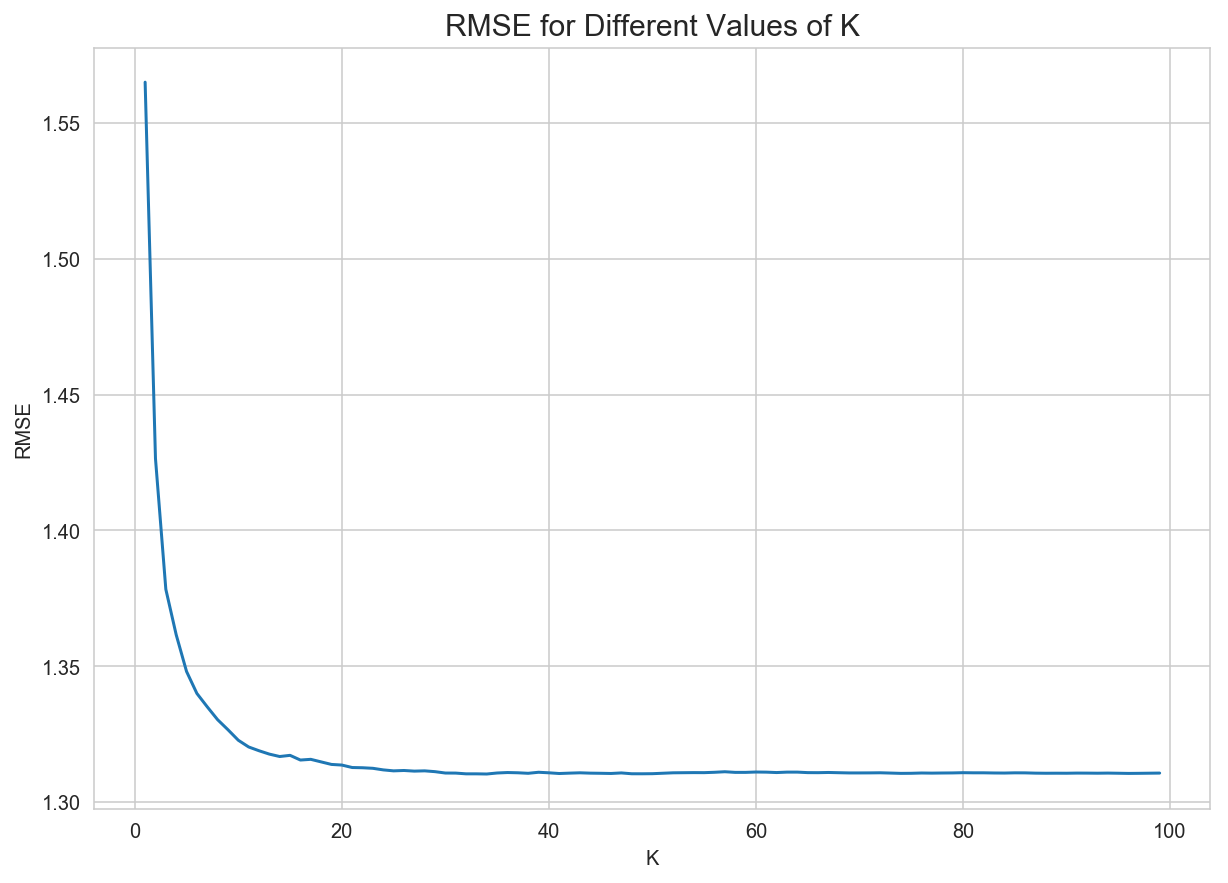

In [17]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBasic', 
                   sim_options={'name': 'cosine', 'user_based': True})

In [18]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
33,34,1.310295
32,33,1.310358
31,32,1.310359
48,49,1.310380
47,48,1.310388


In [19]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBasic(k=best_k, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 1.A.3. Evaluate Model

**Get Recommendations for Example User**

In [20]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [21]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [22]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNBasic - Cosine):', prec)


Precision (UU - KNNBasic - Cosine): 0.0057757057757057756


In [23]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNBasic - Cosine):', mean_ap)


MAP (UU - KNNBasic - Cosine): 0.05357548842805598


In [24]:
algo_1A = {'Model': 'UU - KNNBasic - Cosine',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [25]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBasic',
#             sim_options={'name': 'cosine', 'user_based': True})

### 1.A.4. Make Recommendations for New Customer

In [26]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


,items,rating
20,The Legend of Zelda: Twilight Princess,5.0
213,Civilization 3,5.0
173,The Sims 3,5.0
94,Kingdom Hearts,5.0
122,Dance Central 2 - Xbox 360,5.0
202,Grand Theft Auto: San Andreas,5.0
127,Lego Star Wars: The Complete Saga,5.0
174,The Sims 2,5.0
181,Resident Evil,5.0
172,Dance Central 3,5.0


<br>

## 1.B. User-User Collaborative Filtering (KNNBasic - Pearson)

A basic collaborative filtering algorithm.

$${\normalsize \hat{r}_{ui} = \frac{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot r_{vi}}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
${v \in N^k_i(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - Similarity between user $u$ and $v$.<br>
$r_{vi}$ - Rating for user $v$ and item $i$.<br>

### 1.B.1. Train Model

In [27]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBasic(k=50, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


### 1.B.2. Evaluate Model (RMSE)

In [28]:
# Evaluate test set
print("User-based (KNNBasic - Pearson) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (KNNBasic - Pearson) Model : Test Set
RMSE: 1.2442


**Search Best K based on RMSE**

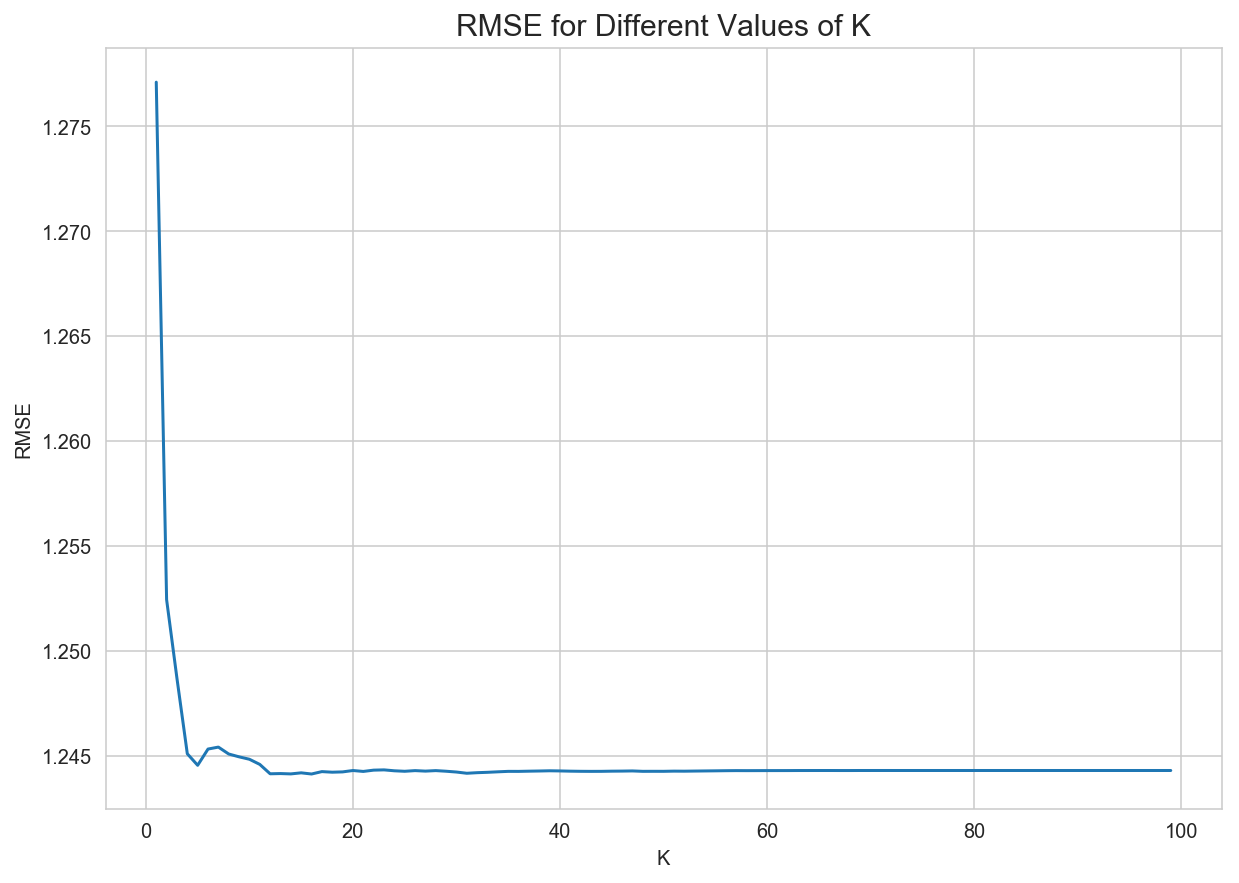

In [29]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBasic', 
                   sim_options={'name': 'pearson', 'user_based': True})

In [30]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
15,16,1.244121
13,14,1.244126
11,12,1.244131
12,13,1.244142
30,31,1.244156


In [31]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBasic(k=best_k, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### 1.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [32]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [33]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [34]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNBasic - Pearson):', prec)


Precision (UU - KNNBasic - Pearson): 0.014529914529914529


In [35]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNBasic - Pearson):', mean_ap)


MAP (UU - KNNBasic - Pearson): 0.15483893099672694


In [36]:
algo_1B = {'Model': 'UU - KNNBasic - Pearson',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [37]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBasic',
#             sim_options={'name': 'pearson', 'user_based': True})

### 1.B.4. Make Recommendations for New Customer

In [38]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,items,rating
27,Call of Duty: Ghosts,5.000000
4,Battlefield 3,5.000000
5,Call of Duty: Modern Warfare 2,5.000000
0,Battlefield 4,4.144596
152,Gears Of War - Xbox 360,4.144596
141,Mario Kart DS,4.144596
142,Mario Kart: Double Dash,4.144596
143,Super Smash Bros. Brawl,4.144596
144,Super Mario Galaxy (Nintendo Selects),4.144596
145,Super Mario 64,4.144596


<br>
## 2.A. Item-Item Collaborative Filtering (KNNBasic - Cosine)

A basic collaborative filtering algorithm.

$${\normalsize \hat{r}_{ui} = \frac{\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j) \cdot r_{uj}}{\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - Similarity between item $i$ and $j$.<br>
$r_{uj}$ - Rating for item $j$ and user $u$.<br>

### 2.A.1. Train Model

In [39]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


### 2.A.2. Evaluate Model (RMSE)

In [40]:
# Evaluate test set
print("Item-based (KNNBasic - Cosine) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (KNNBasic - Cosine) Model : Test Set
RMSE: 1.3028


**Search Best K based on RMSE**

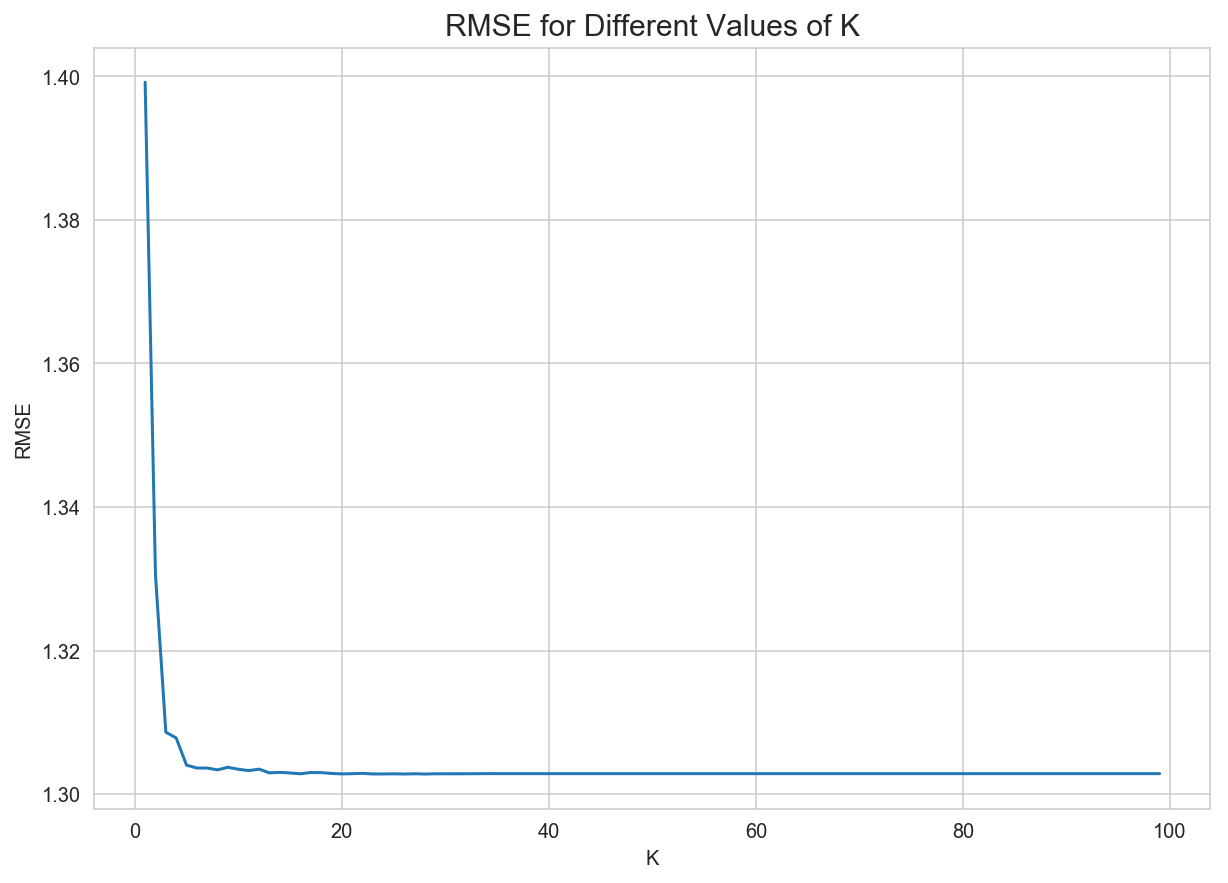

In [41]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBasic', 
                   sim_options={'name': 'cosine', 'user_based': False})

In [42]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
27,28,1.302795
25,26,1.302797
23,24,1.302800
22,23,1.302802
19,20,1.302810


In [43]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBasic(k=best_k, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 2.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [44]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [45]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [46]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBasic - Cosine):', prec)


Precision (II - KNNBasic - Cosine): 0.009298109298109298


In [47]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBasic - Cosine):', mean_ap)


MAP (II - KNNBasic - Cosine): 0.09721521262370526


In [48]:
algo_2A = {'Model': 'II - KNNBasic - Cosine',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [49]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBasic',
#             sim_options={'name': 'cosine', 'user_based': False})

### 2.A.4. Make Recommendations for New Customer

In [50]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


,items,rating
0,Battlefield 4,5.0
158,Resident Evil 4,5.0
126,Demon's Souls,5.0
127,Lego Star Wars: The Complete Saga,5.0
129,Diablo III - PC/Mac,5.0
131,Mass Effect 2,5.0
132,PlayStation All-Stars Battle Royale,5.0
133,NBA 2K14,5.0
134,Rocksmith,5.0
136,New Super Mario Bros,5.0


<br>
## 2.B. Item-Item Collaborative Filtering (KNNBasic - Pearson)

A basic collaborative filtering algorithm.

$${\normalsize \hat{r}_{ui} = \frac{\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j) \cdot r_{uj}}{\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - Similarity between item $i$ and $j$.<br>
$r_{uj}$ - Rating for item $j$ and user $u$.<br>

### 2.B.1. Train Model

In [51]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBasic(k=50, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


### 2.B.2. Evaluate Model (RMSE)

In [52]:
# Evaluate test set
print("Item-based (KNNBasic - Pearson) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (KNNBasic - Pearson) Model : Test Set
RMSE: 1.2791


**Search Best K based on RMSE**

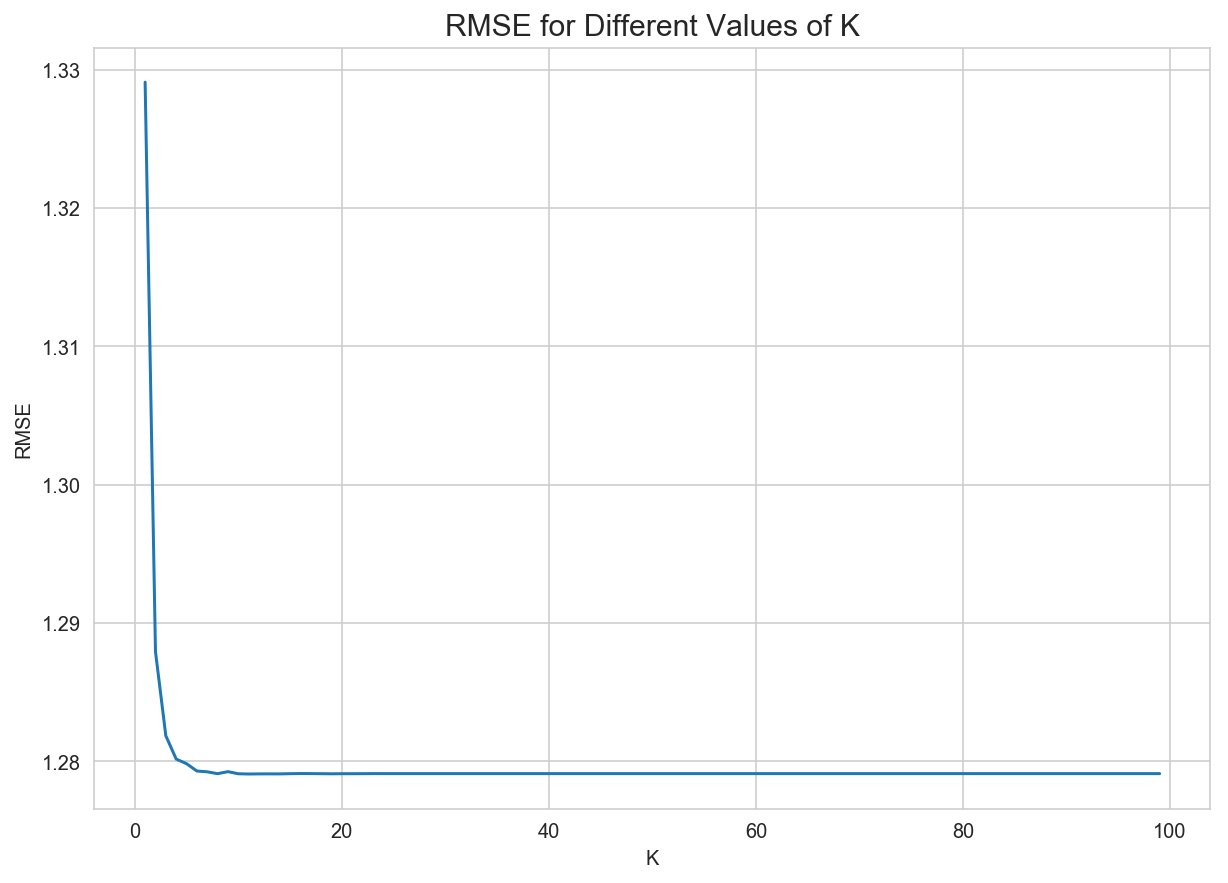

In [53]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBasic', 
                   sim_options={'name': 'pearson', 'user_based': False})

In [54]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
10,11,1.279083
11,12,1.279091
13,14,1.279091
12,13,1.279092
18,19,1.279098


In [55]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBasic(k=best_k, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### 2.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [56]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [57]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [58]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBasic - Pearson):', prec)


Precision (II - KNNBasic - Pearson): 0.014141414141414144


In [59]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBasic - Pearson):', mean_ap)


MAP (II - KNNBasic - Pearson): 0.13567697673748935


In [60]:
algo_2B = {'Model': 'II - KNNBasic - Pearson',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [61]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBasic',
#             sim_options={'name': 'pearson', 'user_based': False})

### 2.B.4. Make Recommendations for New Customer

In [62]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,items,rating
0,Battlefield 4,5.0
103,Killzone: Shadow Fall (PlayStation 4),5.0
105,Call of Duty: Black Ops II - PlayStation 3,5.0
106,Ryse: Son of Rome,5.0
107,Red Dead Redemption,5.0
109,Assassin's Creed Ezio Trilogy Edition,5.0
111,Killzone 3,5.0
112,Killzone 2 - Playstation 3,5.0
114,Need for Speed Most Wanted,5.0
115,Super Mario Galaxy 2,5.0


<br>
## 3.A. User-User Collaborative Filtering (KNNwithMeans - Cosine)

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.

$${\normalsize \hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - \mu_v)}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_u$ - Mean rating for user $u$.<br>
${v \in N^k_i(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - Similarity between user $u$ and $v$.<br>
$(r_{vi} - \mu_v)$ - Deviation of rating for user $v$ and its mean rating.<br>

### 3.A.1. Train Model

In [63]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


### 3.A.2. Evaluate Model (RMSE)

In [64]:
# Evaluate test set
print("User-based (KNNwithMeans - Cosine) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (KNNwithMeans - Cosine) Model : Test Set
RMSE: 1.2883


**Search Best K based on RMSE**

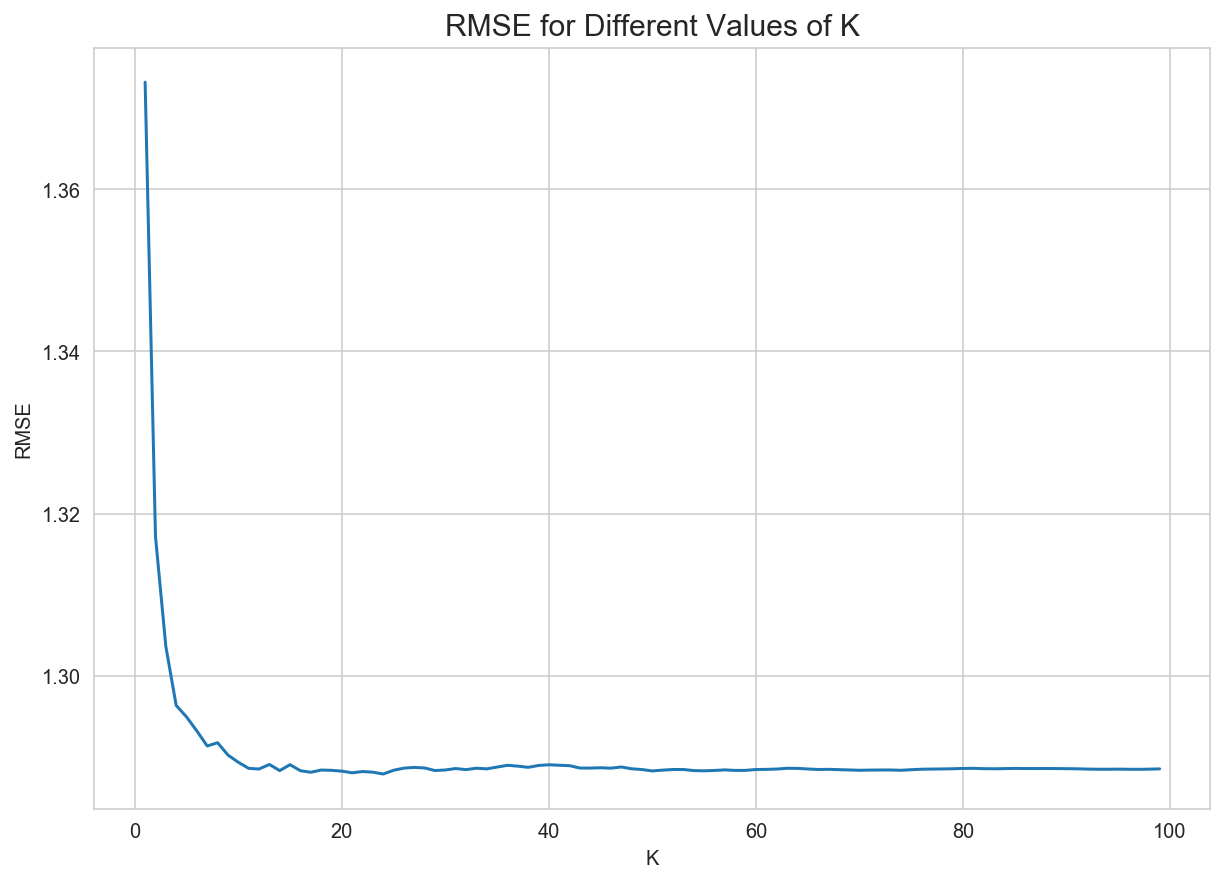

In [65]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithMeans', 
                   sim_options={'name': 'cosine', 'user_based': True})

In [66]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(2)

,k,test_rmse
23,24,1.287879
20,21,1.288028


In [67]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithMeans(k=best_k, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 3.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [68]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [69]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [70]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Recall (UU - KNNwithMeans - Cosine):', prec)


Recall (UU - KNNwithMeans - Cosine): 0.009945609945609947


In [71]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNwithMeans - Cosine):', mean_ap)


MAP (UU - KNNwithMeans - Cosine): 0.09426740234081922


In [72]:
algo_3A = {'Model': 'UU - KNNwithMeans - Cosine',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [73]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithMeans',
#             sim_options={'name': 'cosine', 'user_based': True})

### 3.A.4. Make Recommendations for New Customer

In [74]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


,items,rating
110,Call of Duty 4: Modern Warfare,5.0
142,Mario Kart: Double Dash,5.0
133,NBA 2K14,5.0
134,Rocksmith,5.0
135,God of War III,5.0
136,New Super Mario Bros,5.0
138,Donkey Kong Country Returns,5.0
139,Super Smash Bros Melee,5.0
140,Michael Jackson The Experience,5.0
141,Mario Kart DS,5.0


<br>
## 3.B. User-User Collaborative Filtering (KNNwithMeans - Pearson)

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.

$${\normalsize \hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - \mu_v)}{\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_u$ - Mean rating for user $u$.<br>
${v \in N^k_i(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - Pearson similarity between user $u$ and $v$.<br>
$(r_{vi} - \mu_v)$ - Deviation of rating for user $v$ and its mean rating.<br>

### 3.B.1. Train Model

In [75]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


### 3.B.2. Evaluate Model (RMSE)

In [76]:
# Evaluate test set
print("User-based (KNNwithMeans - Pearson) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (KNNwithMeans - Pearson) Model : Test Set
RMSE: 1.3275


**Search Best K based on RMSE**

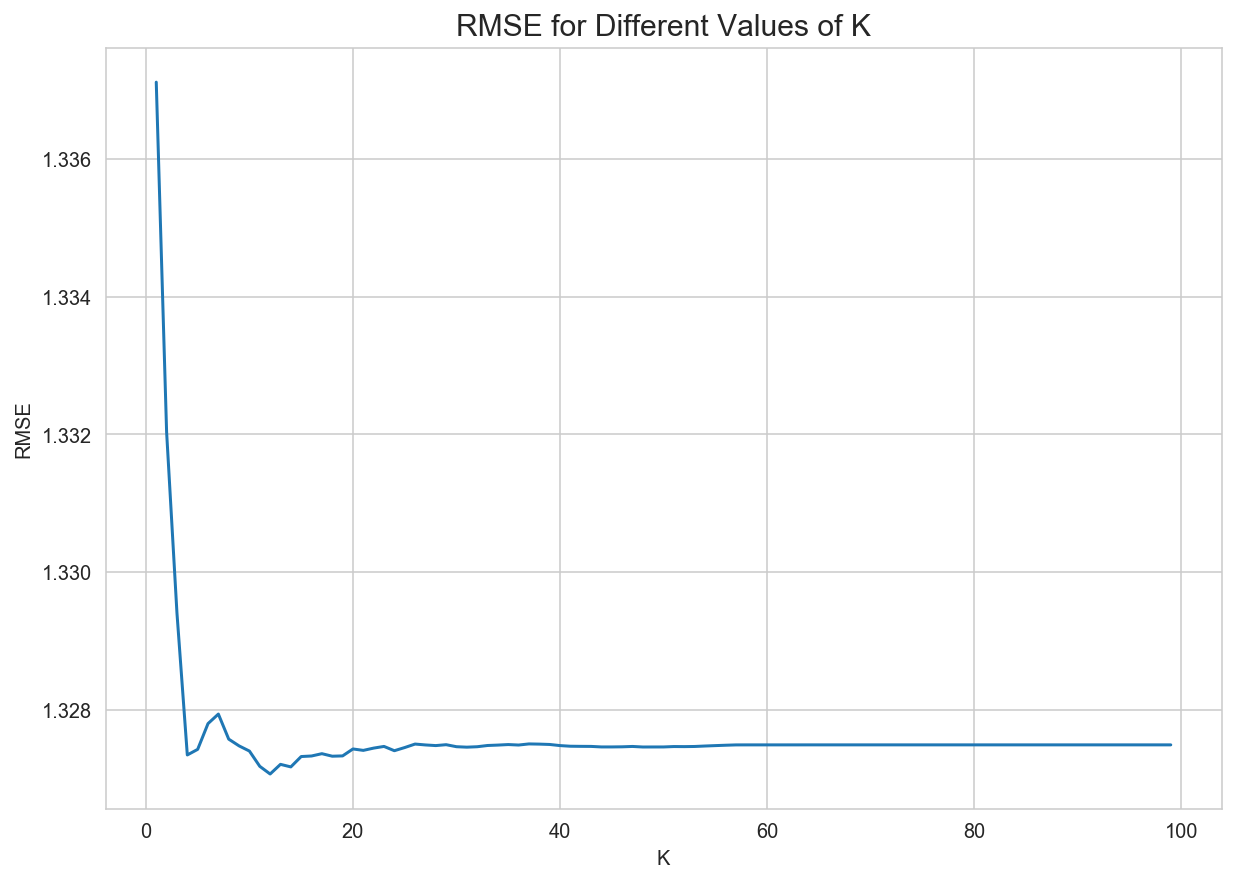

In [77]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithMeans', 
                   sim_options={'name': 'pearson', 'user_based': True})

In [78]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(2)

,k,test_rmse
11,12,1.327067
13,14,1.327170


In [79]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithMeans(k=best_k, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### 3.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [80]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [81]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [82]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNwithMeans - Pearson):', prec)


Precision (UU - KNNwithMeans - Pearson): 0.0150997150997151


In [83]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNwithMeans - Pearson):', mean_ap)


MAP (UU - KNNwithMeans - Pearson): 0.16112363903844634


In [84]:
algo_3B = {'Model': 'UU - KNNwithMeans - Pearson',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [85]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithMeans',
#             sim_options={'name': 'pearson', 'user_based': True})

### 3.B.4. Make Recommendations for New Customer

In [86]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,items,rating
0,Battlefield 4,5
152,Gears Of War - Xbox 360,5
141,Mario Kart DS,5
142,Mario Kart: Double Dash,5
143,Super Smash Bros. Brawl,5
144,Super Mario Galaxy (Nintendo Selects),5
145,Super Mario 64,5
146,Uncharted 2: Among Thieves - Playstation 3,5
147,NBA 2K13,5
148,Gran Turismo 6,5


<br>
## 4.A. Item-Item Collaborative Filtering (KNNwithMeans - Cosine)

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.

$${\normalsize \hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_i$ - Mean rating for item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **Cosine** similarity between item $i$ and $j$.<br>
$(r_{uj} - \mu_j)$ - Deviation of rating for item $j$ and their mean rating.<br>

### 4.A.1. Train Model

In [87]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


### 4.A.2. Evaluate Model (RMSE)

In [88]:
# Evaluate test set
print("Item-based (KNNwithMeans - Cosine) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (KNNwithMeans - Cosine) Model : Test Set
RMSE: 1.2245


**Search Best K based on RMSE**

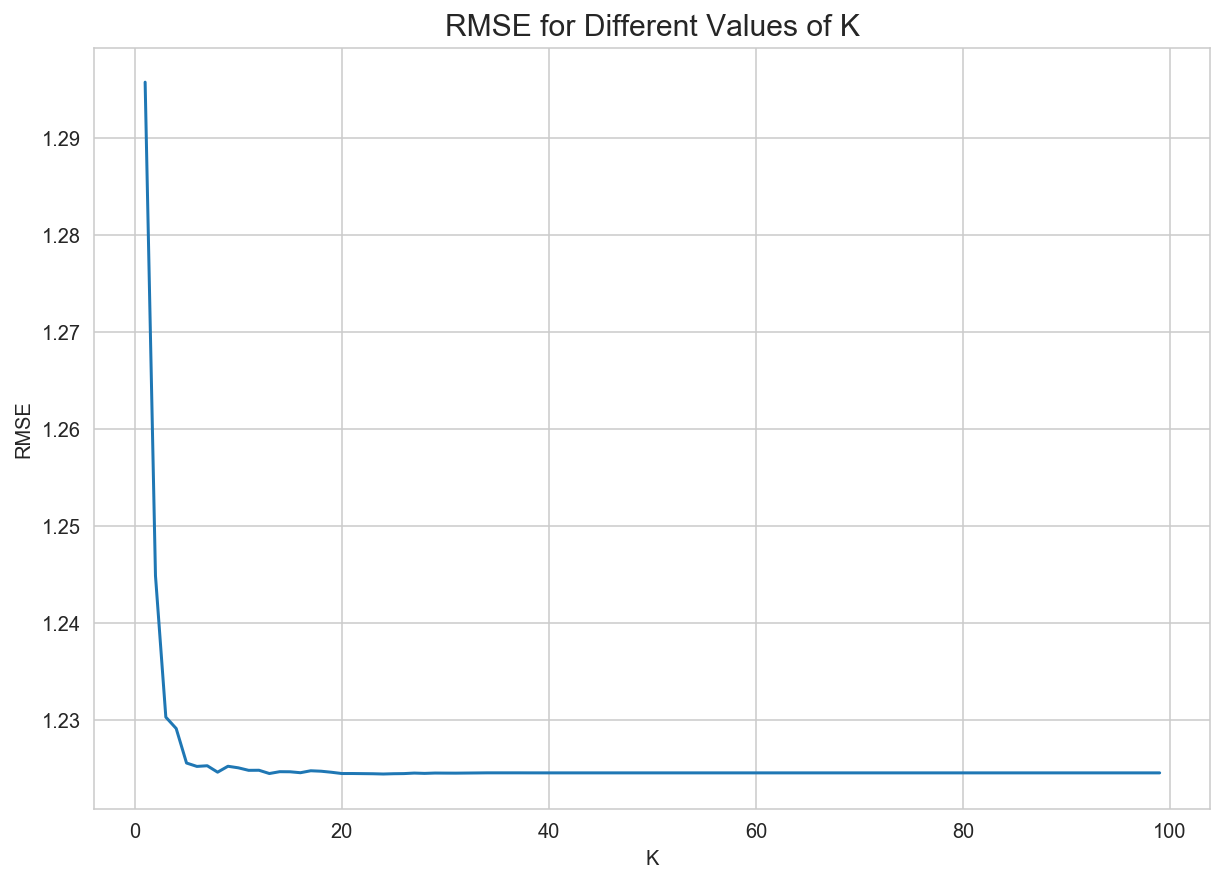

In [89]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithMeans', 
                   sim_options={'name': 'cosine', 'user_based': False})

In [90]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
23,24,1.224428
22,23,1.224455
24,25,1.224457
21,22,1.224467
25,26,1.224471


In [91]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithMeans(k=best_k, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 4.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [92]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [93]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [94]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNwithMeans - Cosine):', prec)


Precision (II - KNNwithMeans - Cosine): 0.009453509453509455


In [95]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNwithMeans - Cosine):', mean_ap)


MAP (II - KNNwithMeans - Cosine): 0.09583039392369522


In [96]:
algo_4A = {'Model': 'II - KNNwithMeans - Cosine',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [97]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithMeans',
#             sim_options={'name': 'cosine', 'user_based': False})

### 4.A.4. Make Recommendations for New Customer

In [98]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


,items,rating
110,Call of Duty 4: Modern Warfare,5.0
142,Mario Kart: Double Dash,5.0
131,Mass Effect 2,5.0
132,PlayStation All-Stars Battle Royale,5.0
134,Rocksmith,5.0
135,God of War III,5.0
136,New Super Mario Bros,5.0
137,Mortal Kombat vs. DC Universe,5.0
138,Donkey Kong Country Returns,5.0
139,Super Smash Bros Melee,5.0


<br>
## 4.B. Item-Item Collaborative Filtering (KNNwithMeans - Pearson)

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.

$${\normalsize \hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_i$ - Mean rating for item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **Pearson** similarity between item $i$ and $j$.<br>
$(r_{uj} - \mu_j)$ - Deviation of rating for item $j$ and their mean rating.<br>

### 4.B.1. Train Model

In [99]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


### 4.B.2. Evaluate Model (RMSE)

In [100]:
# Evaluate test set
print("Item-based (KNNwithMeans - Pearson) Model : Test Set")
test_pred = algo.test(testset)
accuracy.rmse(test_pred, verbose=True)

Item-based (KNNwithMeans - Pearson) Model : Test Set
RMSE: 1.2180


1.2180139516553858

**Search Best K based on RMSE**

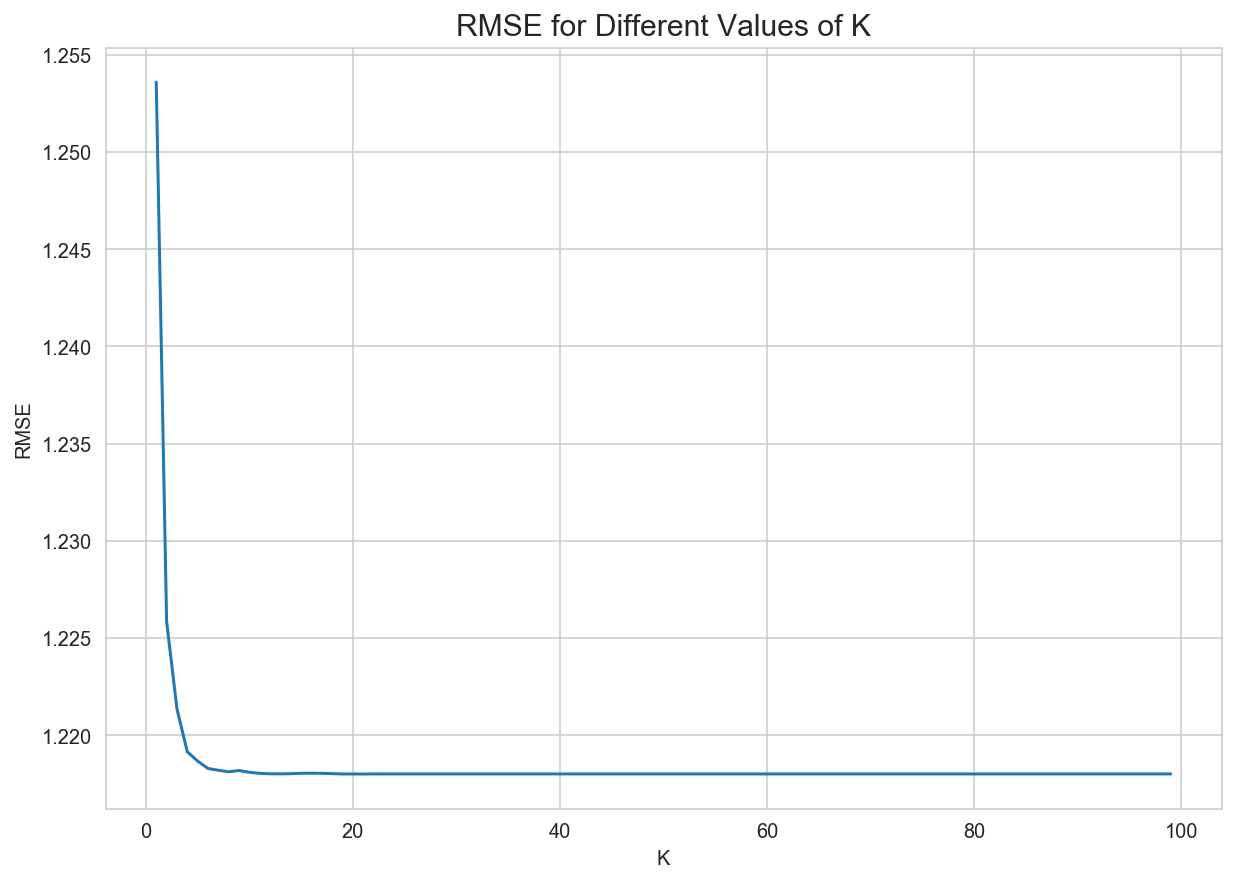

In [101]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithMeans', 
                   sim_options={'name': 'pearson', 'user_based': False})

In [102]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(2)

,k,test_rmse
20,21,1.218010
18,19,1.218011


In [103]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithMeans(k=best_k, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### 4.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [104]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [105]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [106]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNwithMeans - Pearson):', prec)


Precision (II - KNNwithMeans - Pearson): 0.012173012173012173


In [107]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNwithMeans - Pearson):', mean_ap)


MAP (II - KNNwithMeans - Pearson): 0.13274915661455847


In [108]:
algo_4B = {'Model': 'II - KNNwithMeans - Pearson',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [109]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithMeans',
#             sim_options={'name': 'pearson', 'user_based': False})

### 4.B.4. Make Recommendations for New Customer

In [110]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,items,rating
110,Call of Duty 4: Modern Warfare,5.0
64,Assassins Creed II,5.0
155,Need for Speed: Hot Pursuit,5.0
156,Batman: Arkham Asylum,5.0
157,inFAMOUS - Playstation 3,5.0
97,Fallout 3,5.0
96,Medal of Honor: Allied Assault - PC,5.0
162,Ryse: Son of Rome Day One Edition - Xbox One,5.0
93,Call of Duty: World at War,5.0
92,Halo 3: ODST,5.0


<br>
## 5.A. User-User Collaborative Filtering (KNNBaseline - Cosine)

A basic collaborative filtering algorithm taking into account a *baseline* rating.

$${\normalsize \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$b_{ui}$ - Baseline estimate for user $u$ and item $i$.<br>
${v \in N^k_u(i)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **Cosine** similarity between user $u$ and $v$.<br>
$(r_{vi} - b_{vi})$ - Deviation of rating for user $u$ item $i$ and its baseline estimate.<br>

### 5.A.1. Train Model

In [111]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBaseline(k=50, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


### 5.A.2. Evaluate Model (RMSE)

In [112]:
# Evaluate test set
print("User-based (KNNBaseline - Cosine) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (KNNBaseline - Cosine) Model : Test Set
RMSE: 1.2233


**Search Best K based on RMSE**

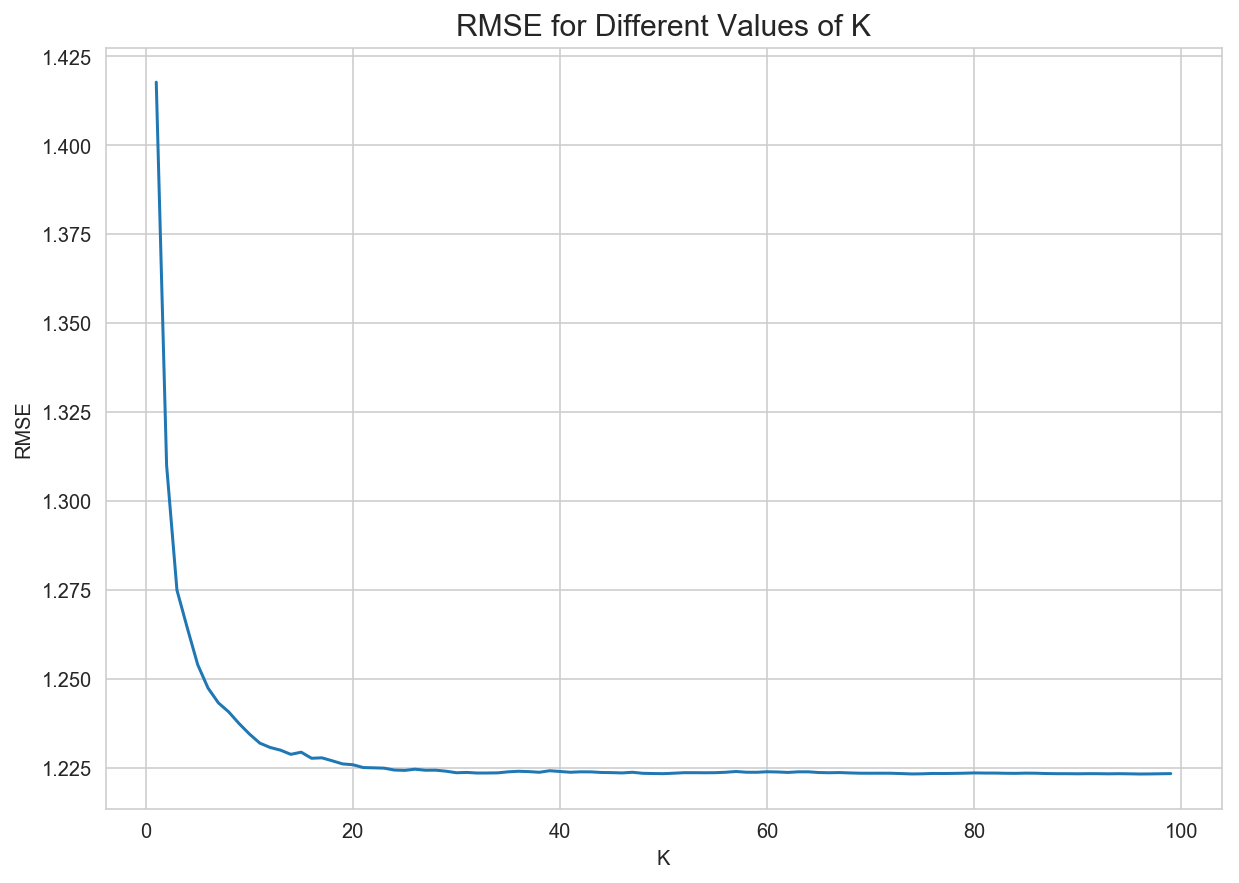

In [113]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBaseline', 
                   sim_options={'name': 'cosine', 'user_based': True})

In [114]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(2)

,k,test_rmse
95,96,1.223185
73,74,1.223202


In [115]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBaseline(k=best_k, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


### 5.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [116]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [117]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [118]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNBaseline - Cosine):', prec)


Precision (UU - KNNBaseline - Cosine): 0.0049987049987049986


In [119]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNBaseline - Cosine):', mean_ap)


MAP (UU - KNNBaseline - Cosine): 0.052500369247289846


In [120]:
algo_5A = {'Model': 'UU - KNNBaseline - Cosine',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [121]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBaseline',
#             sim_options={'name': 'cosine', 'user_based': True})

### 5.A.4. Make Recommendations for New Customer

In [122]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


,items,rating
149,Metal Gear Solid: The Legacy Collection,5.0
141,Mario Kart DS,5.0
139,Super Smash Bros Melee,5.0
65,Metal Gear Solid 2: Sons of Liberty,5.0
168,StarCraft Battle Chest,5.0
96,Medal of Honor: Allied Assault - PC,5.0
78,Just Dance 3,5.0
38,Kingdom Hearts 3D Dream Drop Distance,5.0
174,The Sims 2,5.0
181,Resident Evil,5.0


<br>
## 5.B. User-User Collaborative Filtering (KNNBaseline - Pearson)

A basic collaborative filtering algorithm taking into account a *baseline* rating.

$${\normalsize \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$b_{ui}$ - Baseline estimate for user $u$ and item $i$.<br>
${v \in N^k_u(i)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **Pearson** similarity between user $u$ and $v$.<br>
$(r_{vi} - b_{vi})$ - Deviation of rating for user $u$ item $i$ and its baseline estimate.<br>

### 5.B.1. Train Model

In [123]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBaseline(k=50, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


### 5.B.2. Evaluate Model (RMSE)

In [124]:
# Evaluate test set
print("User-based (KNNBaseline - Pearson) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (KNNBaseline - Pearson) Model : Test Set
RMSE: 1.1802


**Search Best K based on RMSE**

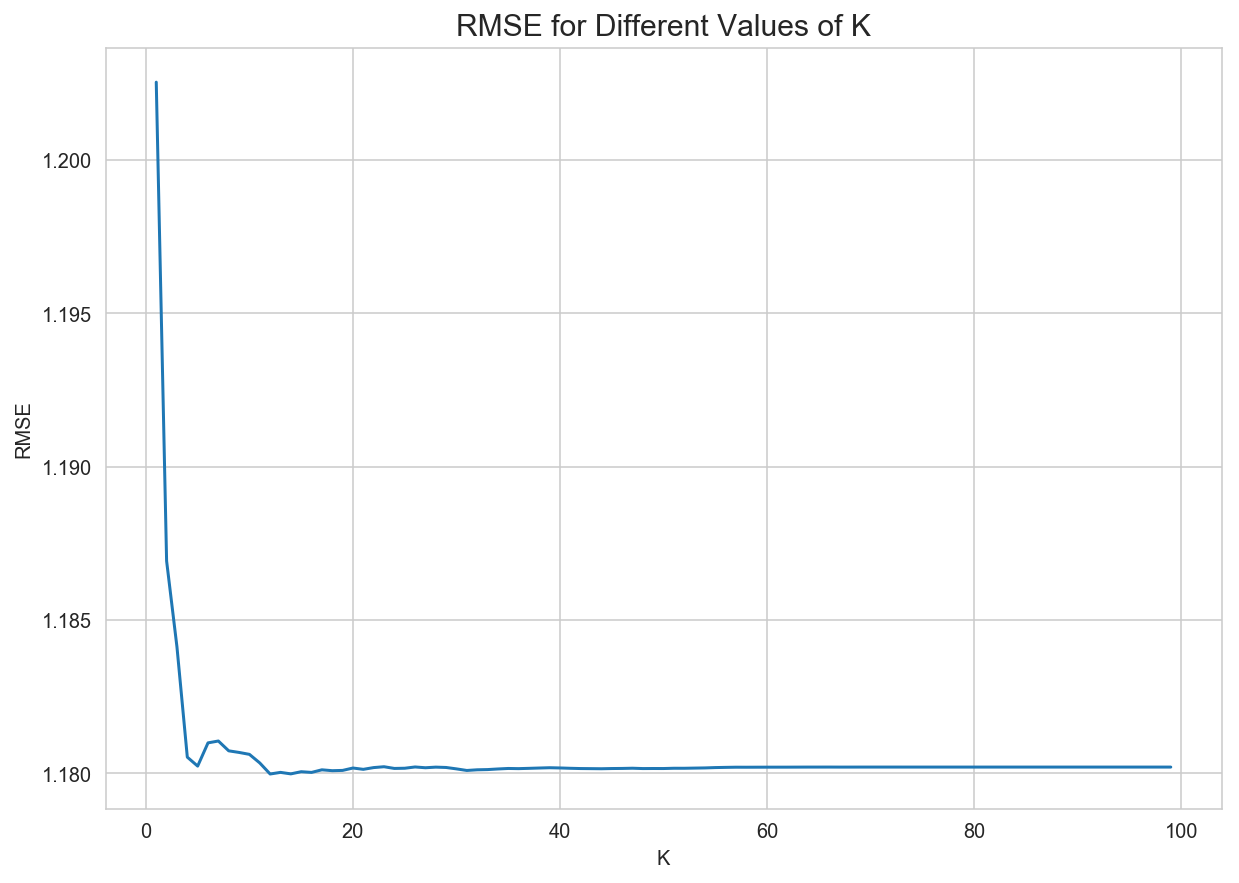

In [125]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBaseline', 
                   sim_options={'name': 'pearson', 'user_based': True})

In [126]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
11,12,1.179980
13,14,1.179985
15,16,1.180032
12,13,1.180033
14,15,1.180055


In [127]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBaseline(k=best_k, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


### 5.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [128]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [129]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [130]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNBaseline - Pearson):', prec)


Precision (UU - KNNBaseline - Pearson): 0.010929810929810931


In [131]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNBaseline - Pearson):', mean_ap)


MAP (UU - KNNBaseline - Pearson): 0.07375043237350952


In [132]:
algo_5B = {'Model': 'UU - KNNBaseline - Pearson',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [133]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBaseline',
#             sim_options={'name': 'pearson', 'user_based': True})

### 5.B.4. Make Recommendations for New Customer

In [134]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


,items,rating
27,Call of Duty: Ghosts,5.000000
4,Battlefield 3,5.000000
5,Call of Duty: Modern Warfare 2,5.000000
141,Mario Kart DS,4.973049
145,Super Mario 64,4.961388
172,Dance Central 3,4.946388
66,Fire Emblem: Awakening,4.944190
158,Resident Evil 4,4.894460
166,Portal 2,4.889947
26,Mortal Kombat Komplete Edition,4.888863


<br>
## 6.A. Item-Item Collaborative Filtering (KNNBaseline - Cosine)

A basic collaborative filtering algorithm taking into account a *baseline* rating.

$${\normalsize \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$b_{ui}$ - Baseline estimate for user $u$ and item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **Cosine** similarity between items $i$ and $j$.<br>
$(r_{uj} - b_{uj})$ - Deviation of rating for user $u$ item $j$ and its baseline estimate.<br>

### 6.A.1. Train Model

In [135]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBaseline(k=50, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


### 6.A.2. Evaluate Model (RMSE)

In [136]:
# Evaluate test set
print("Item-based (KNNBaseline - Cosine) Model : Test Set")
test_pred = algo.test(testset)
accuracy.rmse(test_pred, verbose=True)

Item-based (KNNBaseline - Cosine) Model : Test Set
RMSE: 1.2211


1.2210928807638854

**Search Best K based on RMSE**

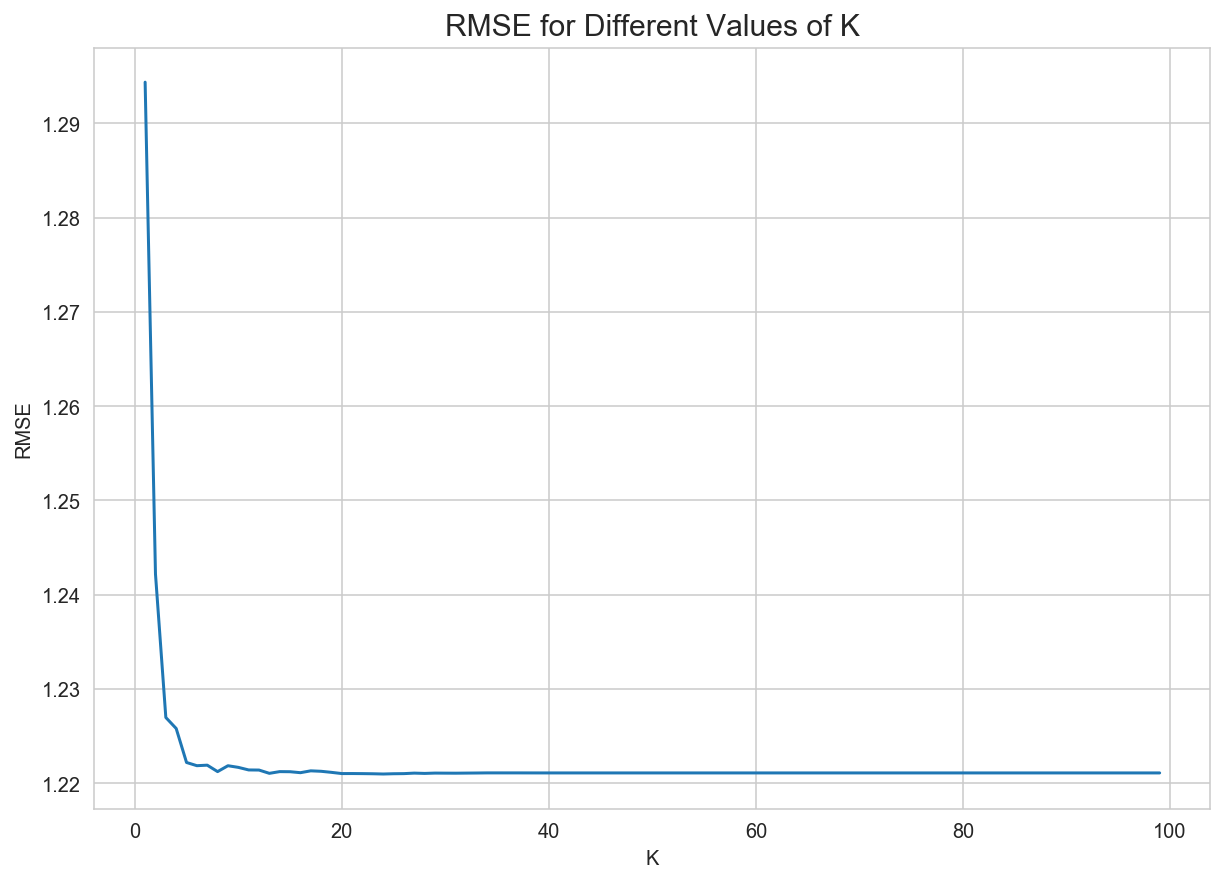

In [137]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBaseline', 
                   sim_options={'name': 'cosine', 'user_based': False})

In [138]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
23,24,1.220979
22,23,1.221005
24,25,1.221008
25,26,1.221020
21,22,1.221020


In [139]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBaseline(k=best_k, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


### 6.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [140]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [141]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [142]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBaseline - Cosine):', prec)


Precision (II - KNNBaseline - Cosine): 0.01131831131831132


In [143]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBaseline - Cosine):', mean_ap)


MAP (II - KNNBaseline - Cosine): 0.11408069689488343


In [144]:
algo_6A = {'Model': 'II - KNNBaseline - Cosine',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [145]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBaseline',
#             sim_options={'name': 'cosine', 'user_based': False})

### 6.A.4. Make Recommendations for New Customer

In [146]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


,items,rating
110,Call of Duty 4: Modern Warfare,5.0
97,Fallout 3,5.0
133,NBA 2K14,5.0
134,Rocksmith,5.0
135,God of War III,5.0
136,New Super Mario Bros,5.0
137,Mortal Kombat vs. DC Universe,5.0
138,Donkey Kong Country Returns,5.0
139,Super Smash Bros Melee,5.0
141,Mario Kart DS,5.0


<br>
## 6.B. Item-Item Collaborative Filtering (KNNBaseline - Pearson)

A basic collaborative filtering algorithm taking into account a *baseline* rating.

$${\normalsize \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$b_{ui}$ - Baseline estimate for user $u$ and item $i$.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **pearson** similarity between items $i$ and $j$.<br>
$(r_{uj} - b_{uj})$ - Deviation of rating for user $u$ item $j$ and its baseline estimate.<br>

### 6.B.1. Train Model

In [147]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNBaseline(k=50, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)


Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


### 6.B.2. Evaluate Model (RMSE)

In [148]:
# Evaluate test set
print("Item-based (KNNBaseline - Pearson) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (KNNBaseline - Pearson) Model : Test Set
RMSE: 1.2081


**Search Best K based on RMSE**

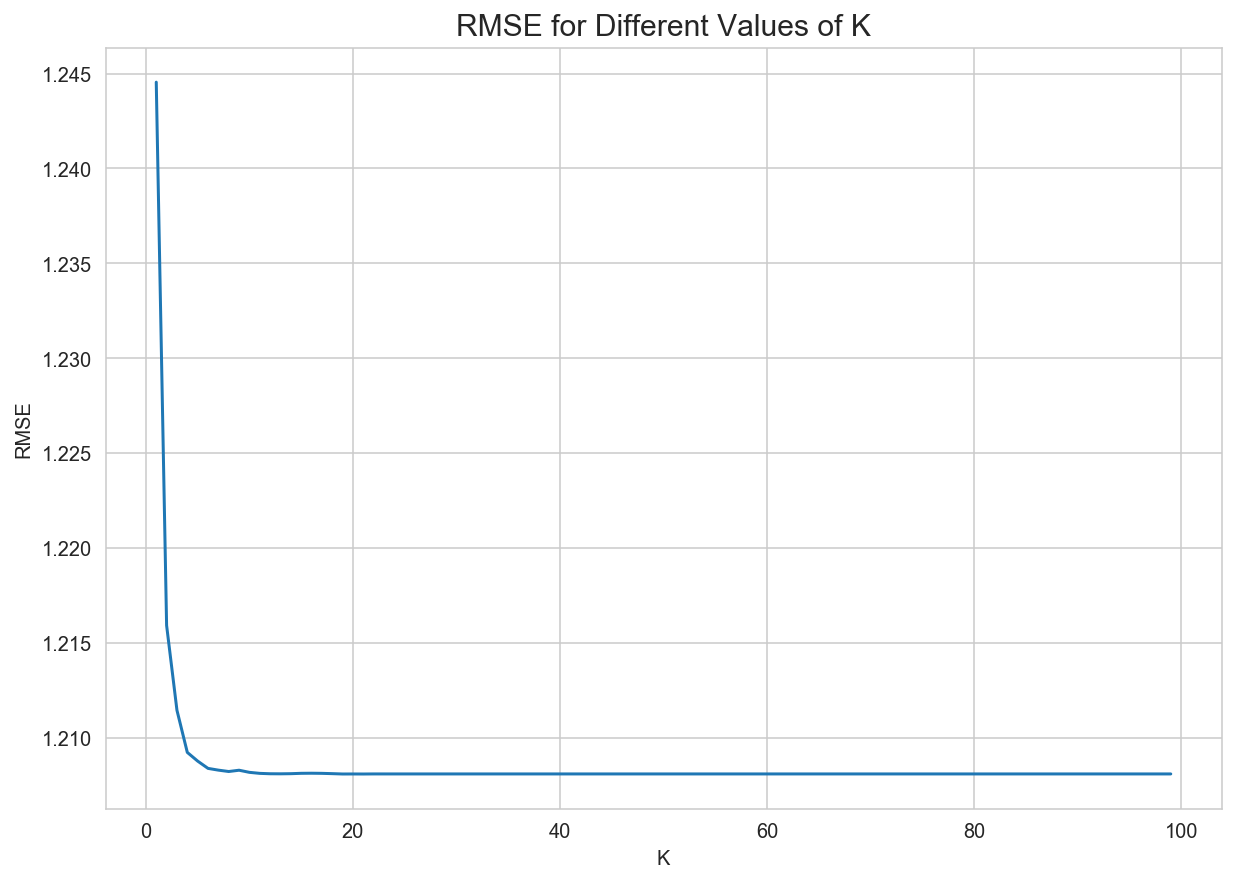

In [149]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNBaseline', 
                   sim_options={'name': 'pearson', 'user_based': False})

In [150]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
20,21,1.208082
18,19,1.208082
19,20,1.208084
49,50,1.208085
72,73,1.208085


In [151]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNBaseline(k=best_k, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


### 6.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [152]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [153]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [154]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBaseline - Pearson):', prec)


Precision (II - KNNBaseline - Pearson): 0.014763014763014764


In [155]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBaseline - Pearson):', mean_ap)


MAP (II - KNNBaseline - Pearson): 0.16388582897775134


In [156]:
algo_6B = {'Model': 'II - KNNBaseline - Pearson',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [157]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNBaseline',
#             sim_options={'name': 'cosine', 'user_based': False})

### 6.B.4. Make Recommendations for New Customer

In [158]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


,items,rating
110,Call of Duty 4: Modern Warfare,5.0
164,Dragon Age 2,5.0
155,Need for Speed: Hot Pursuit,5.0
156,Batman: Arkham Asylum,5.0
97,Fallout 3,5.0
157,inFAMOUS - Playstation 3,5.0
93,Call of Duty: World at War,5.0
92,Halo 3: ODST,5.0
91,The Elder Scrolls V: Skyrim Legendary Edition,5.0
90,Minecraft - Xbox 360,5.0


<br>
## 7.A. User-User Collaborative Filtering (KNNWithZScore - Cosine)

A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

$${\normalsize \hat{r}_{ui} = \mu_u + \sigma_u \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - \mu_v) / \sigma_v} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_u$ - Mean rating for user $u$.<br>
$\sigma_u$ - Z-score normalization of user $u$ ratings.<br> 
${v \in N^k_u(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **Cosine** similarity between user $u$ and $v$.<br>
$(r_{vi} - \mu_v) / \sigma_v$ - Deviation of rating for user $v$ item $i$ and mean rating for user $v$, normalized by Z-score of user $v$ ratings, $\sigma_v$.<br>

### 7.A.1. Train Model

In [159]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithZScore(k=50, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


### 7.A.2. Evaluate Model (RMSE)

In [160]:
# Evaluate test set
print("User-based (KNNWithZScore - Cosine) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (KNNWithZScore - Cosine) Model : Test Set
RMSE: 1.2970


**Search Best K based on RMSE**

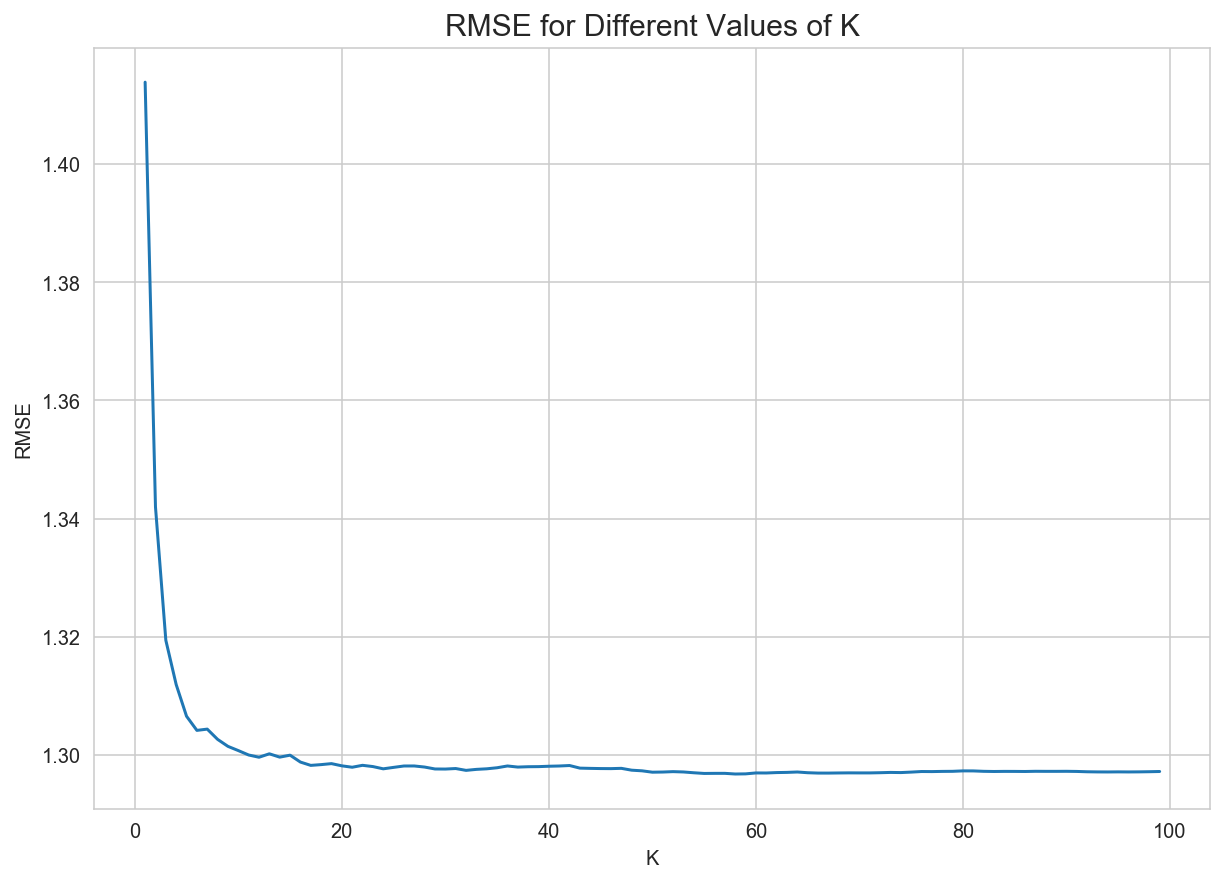

In [161]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithZScore', 
                   sim_options={'name': 'cosine', 'user_based': True})

In [162]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
57,58,1.296737
58,59,1.296761
54,55,1.296833
55,56,1.296848
56,57,1.296849


In [163]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithZScore(k=best_k, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 7.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [164]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [165]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [166]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNWithZScore - Cosine):', prec)


Precision (UU - KNNWithZScore - Cosine): 0.008313908313908314


In [167]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNWithZScore - Cosine):', mean_ap)


MAP (UU - KNNWithZScore - Cosine): 0.07565191971574528


In [168]:
algo_7A = {'Model': 'UU - KNNWithZScore - Cosine',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [169]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithZScore',
#             sim_options={'name': 'cosine', 'user_based': True})

### 7.A.4. Make Recommendations for New Customer

In [170]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


,items,rating
110,Call of Duty 4: Modern Warfare,5.0
142,Mario Kart: Double Dash,5.0
132,PlayStation All-Stars Battle Royale,5.0
133,NBA 2K14,5.0
134,Rocksmith,5.0
135,God of War III,5.0
138,Donkey Kong Country Returns,5.0
139,Super Smash Bros Melee,5.0
140,Michael Jackson The Experience,5.0
141,Mario Kart DS,5.0


<br>
## 7.B. User-User Collaborative Filtering (KNNWithZScore - Pearson)

A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

$${\normalsize \hat{r}_{ui} = \mu_u + \sigma_u \frac{ \sum\limits_{v \in N^k_i(u)}\text{sim}(u, v) \cdot (r_{vi} - \mu_v) / \sigma_v} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_u$ - Mean rating for user $u$.<br>
$\sigma_u$ - Z-score normalization of user $u$ ratings.<br> 
${v \in N^k_u(u)}$ - $v$ users in $k$ neighborhood most similar to user $u$ for item $i$.<br>
$\text{sim}(u, v)$ - **Pearson** similarity between user $u$ and $v$.<br>
$(r_{vi} - \mu_v) / \sigma_v$ - Deviation of rating for user $v$ item $i$ and mean rating for user $v$, normalized by Z-score of user $v$ ratings, $\sigma_v$.<br>

### 7.B.1. Train Model

In [171]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithZScore(k=50, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


### 7.B.2. Evaluate Model (RMSE)

In [172]:
# Evaluate test set
print("User-based (KNNWithZScore - Pearson) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

User-based (KNNWithZScore - Pearson) Model : Test Set
RMSE: 1.3267


**Search Best K based on RMSE**

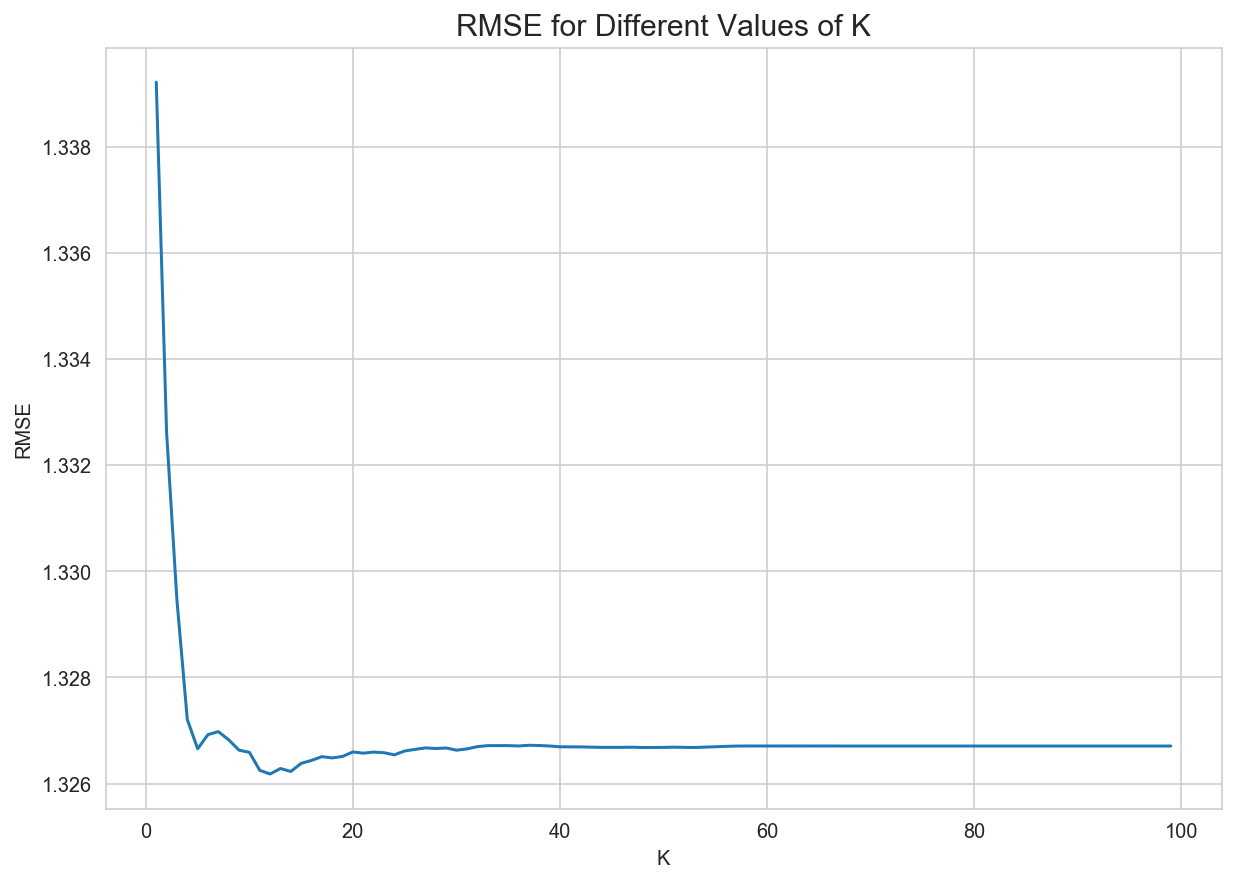

In [173]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithZScore', 
                   sim_options={'name': 'pearson', 'user_based': True})

In [174]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
11,12,1.326181
13,14,1.326228
10,11,1.326250
12,13,1.326285
14,15,1.326382


In [175]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithZScore(k=best_k, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### 7.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [176]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [177]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [178]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNWithZScore - Pearson):', prec)


Precision (UU - KNNWithZScore - Pearson): 0.014685314685314685


In [179]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNWithZScore - Pearson):', mean_ap)


MAP (UU - KNNWithZScore - Pearson): 0.15381109112380856


In [180]:
algo_7B = {'Model': 'UU - KNNWithZScore - Pearson',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [181]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithZScore',
#             sim_options={'name': 'pearson', 'user_based': True})

### 7.B.4. Make Recommendations for New Customer

In [182]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,items,rating
0,Battlefield 4,5
152,Gears Of War - Xbox 360,5
141,Mario Kart DS,5
142,Mario Kart: Double Dash,5
143,Super Smash Bros. Brawl,5
144,Super Mario Galaxy (Nintendo Selects),5
145,Super Mario 64,5
146,Uncharted 2: Among Thieves - Playstation 3,5
147,NBA 2K13,5
148,Gran Turismo 6,5


<br>
## 8.A. Item-Item Collaborative Filtering (KNNWithZScore - Cosine)

A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

$${\normalsize \hat{r}_{ui} = \mu_i + \sigma_i \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - \mu_j) / \sigma_j} {\sum\limits_{j\in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_i$ - Mean rating for item $i$.<br>
$\sigma_i$ - Z-score normalization of item $i$ ratings.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **Cosine** similarity between items $i$ and $j$.<br>
$(r_{uj} - \mu_j) / \sigma_j$ - Deviation of rating for item $j$ user $u$ and mean rating for item $j$, normalized by Z-score of item $j$ ratings, $\sigma_j$.<br>

### 8.A.1. Train Model

In [183]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithZScore(k=50, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


### 8.A.2. Evaluate Model (RMSE)

In [184]:
# Evaluate test set
print("Item-based (KNNWithZScore - Cosine) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (KNNWithZScore - Cosine) Model : Test Set
RMSE: 1.2251


**Search Best K based on RMSE**

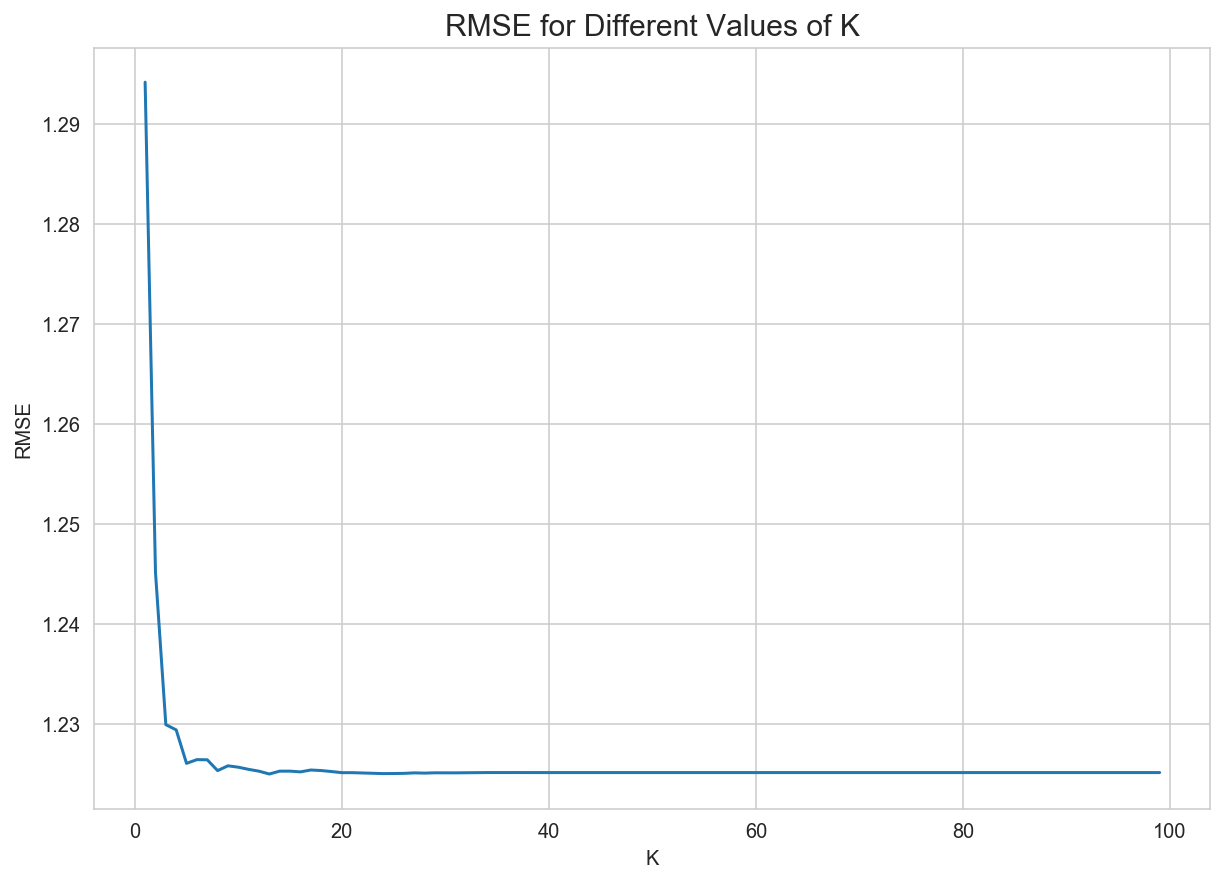

In [185]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithZScore', 
                   sim_options={'name': 'cosine', 'user_based': False})

In [186]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
12,13,1.225002
23,24,1.225042
24,25,1.225050
25,26,1.225066
22,23,1.225075


In [187]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithZScore(k=best_k, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 8.A.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [188]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [189]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [190]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNWithZScore - Cosine):', prec)


Precision (II - KNNWithZScore - Cosine): 0.009116809116809118


In [191]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNWithZScore - Cosine):', mean_ap)


MAP (II - KNNWithZScore - Cosine): 0.10306777383065056


In [192]:
algo_8A = {'Model': 'II - KNNWithZScore - Cosine',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [193]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithZScore',
#             sim_options={'name': 'cosine', 'user_based': False})

### 8.A.4. Make Recommendations for New Customer

In [194]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


,items,rating
110,Call of Duty 4: Modern Warfare,5.0
126,Demon's Souls,5.0
117,Fallout 3: Game of The Year Edition,5.0
119,Batman Arkham Asylum Goty,5.0
120,Heavy Rain - Greatest Hits,5.0
121,PS3 Journey Collection,5.0
122,Dance Central 2 - Xbox 360,5.0
123,Dead Space 3,5.0
202,Grand Theft Auto: San Andreas,5.0
125,Uncharted: Drake's Fortune - Playstation 3,5.0


<br>
## 8.B. Item-Item Collaborative Filtering (KNNWithZScore - Pearson)

A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

$${\normalsize \hat{r}_{ui} = \mu_i + \sigma_i \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - \mu_j) / \sigma_j} {\sum\limits_{j\in N^k_u(i)} \text{sim}(i, j)} }$$

Where:
<br>
$\hat{r}_{ui}$ - Prediction for user $u$ and item $i$.<br>
$\mu_i$ - Mean rating for item $i$.<br>
$\sigma_i$ - Z-score normalization of item $i$ ratings.<br>
${j \in N^k_u(i)}$ - $j$ items in $k$ neighborhood most similar to item $i$ for user $u$.<br>
$\text{sim}(i, j)$ - **Pearson** similarity between items $i$ and $j$.<br>
$(r_{uj} - \mu_j) / \sigma_j$ - Deviation of rating for item $j$ user $u$ and mean rating for item $j$, normalized by Z-score of item $j$ ratings, $\sigma_j$.<br>

### 8.B.1. Train Model

In [195]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# Here we will use user based collaborative filtering, so True.

algo = KNNWithZScore(k=50, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


### 8.B.2. Evaluate Model (RMSE)

In [196]:
# Evaluate test set
print("Item-based (KNNWithZScore - Pearson) Model : Test Set")
test_pred = algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=True)

Item-based (KNNWithZScore - Pearson) Model : Test Set
RMSE: 1.2135


**Search Best K based on RMSE**

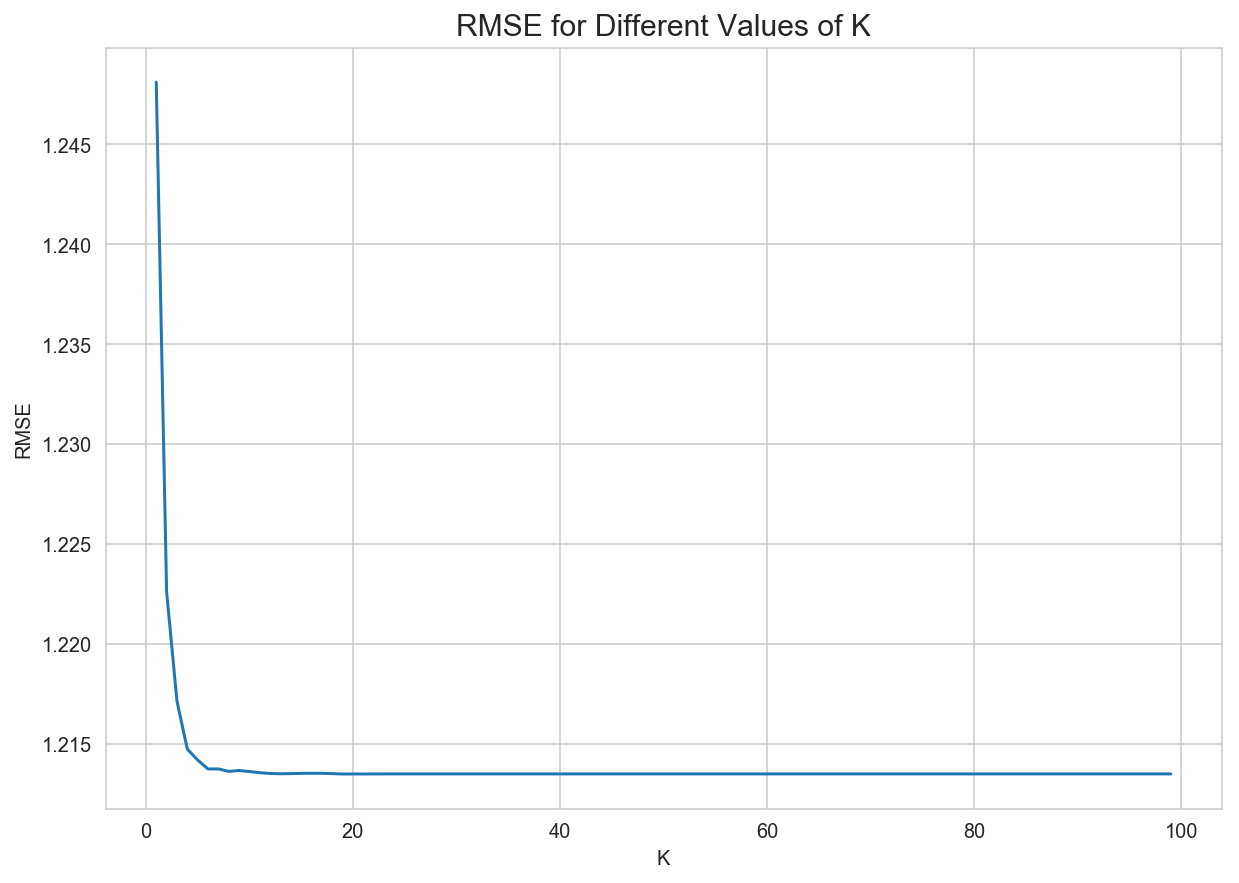

In [197]:
scores = plot_rmse(range(1,100), 
                   trainset, 
                   testset, 
                   algorithm='KNNWithZScore', 
                   sim_options={'name': 'pearson', 'user_based': False})

In [198]:
# Sort rmse scores and pick value of k that has lowest rmse on the test set
scores.sort_values(by='test_rmse', ascending=True, inplace=True)
scores.head(5)

,k,test_rmse
18,19,1.213493
20,21,1.213494
19,20,1.213495
21,22,1.213497
49,50,1.213497


In [199]:
# Refit model with best k
best_k = scores[:1]['k'].values[0]

algo = KNNWithZScore(k=best_k, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### 8.B.3. Evaluate Model (Recall)

**Get Recommendations for Example User**

In [200]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)


In [201]:
print_customer_prof(train_df, test_df, top_n)

Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern Warfare 3 - Xbox 360          5.0
4141                 Call of Duty: Modern Wa

In [202]:
prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNWithZScore - Pearson):', prec)


Precision (II - KNNWithZScore - Pearson): 0.011836311836311836


In [203]:
mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNWithZScore - Pearson):', mean_ap)


MAP (II - KNNWithZScore - Pearson): 0.12917562356953363


In [204]:
algo_8B = {'Model': 'II - KNNWithZScore - Pearson',
           'RMSE': rmse,
           'Unranked Precision': prec,
           'MAP': mean_ap}

**Search Best K based on Recall**

In [205]:
# # HAHAHA
# plot_recall(range(10,61,10), 
#             trainset, 
#             testset,
#             algorithm='KNNWithZScore',
#             sim_options={'name': 'pearson', 'user_based': False})

### 8.B.4. Make Recommendations for New Customer

In [206]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

recs = new_recommendations(new_products, whole, algo)
recs.head(10)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,items,rating
110,Call of Duty 4: Modern Warfare,5.0
75,The Legend of Zelda: Ocarina of Time 3D,5.0
91,The Elder Scrolls V: Skyrim Legendary Edition,5.0
90,Minecraft - Xbox 360,5.0
87,Madden NFL 25,5.0
154,Call of Duty: Modern Warfare 3 - Playstation 3,5.0
84,Mario Party 9,5.0
83,Rocksmith 2014,5.0
155,Need for Speed: Hot Pursuit,5.0
81,Animal Crossing: New Leaf,5.0


### Conclusion

In [207]:
scores = [algo_1A, algo_1B,
          algo_2A, algo_2B,
          algo_3A, algo_3B,
          algo_4A, algo_4B,
          algo_5A, algo_5B,
          algo_6A, algo_6B,
          algo_7A, algo_7B,
          algo_8A, algo_8B]

scores_df(scores).sort_values(by='MAP', ascending=False)

,Model,RMSE,Unranked Precision,MAP
11,II - KNNBaseline - Pearson,1.208085,0.014763,0.163886
5,UU - KNNwithMeans - Pearson,1.327460,0.015100,0.161124
1,UU - KNNBasic - Pearson,1.244249,0.014530,0.154839
13,UU - KNNWithZScore - Pearson,1.326682,0.014685,0.153811
3,II - KNNBasic - Pearson,1.279111,0.014141,0.135677
7,II - KNNwithMeans - Pearson,1.224544,0.012173,0.132749
15,II - KNNWithZScore - Pearson,1.213497,0.011836,0.129176
10,II - KNNBaseline - Cosine,1.180159,0.011318,0.114081
14,II - KNNWithZScore - Cosine,1.225144,0.009117,0.103068
2,II - KNNBasic - Cosine,1.302845,0.009298,0.097215


### Best Item-Item Model

In [208]:
# Best Item-Item CF Model - "II - KNNBaseline - Pearson"
best_ii_algo = KNNBaseline(k=21, sim_options={'name': 'pearson', 'user_based': False})
best_ii_algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
train_pred_set = trainset.build_anti_testset()
train_preds = best_ii_algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)

# Print predicitons
print_customer_prof(train_df, test_df, top_n)


Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3

In [209]:
test_pred = best_ii_algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=False)
print("RMSE (II - KNNBaseline - Pearson):", rmse)

prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (II - KNNBaseline - Pearson):', prec)

mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (II - KNNBaseline - Pearson):', mean_ap)


RMSE (II - KNNBaseline - Pearson): 1.2080815144194483
Precision (II - KNNBaseline - Pearson): 0.014763014763014764
MAP (II - KNNBaseline - Pearson): 0.16388582897775134


In [238]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

# best_ii_algo = KNNBaseline(k=21, sim_options={'name': 'pearson', 'user_based': False})
recs = new_recommendations(new_products, whole, best_ii_algo)
recs.head(15)


Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
user: 1          item: Battlefield 4 r_ui = None   est = 4.85   {'actual_k': 2, 'was_impossible': False}
user: 1          item: Far Cry 3  r_ui = None   est = 5.00   {'actual_k': 3, 'was_impossible': False}
user: 1          item: Valkyria Chronicles r_ui = None   est = 4.71   {'actual_k': 0, 'was_impossible': False}
user: 1          item: Pokemon Y  r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}
user: 1          item: Battlefield 3 r_ui = None   est = 5.00   {'actual_k': 3, 'was_impossible': False}
user: 1          item: Call of Duty: Modern Warfare 2 r_ui = None   est = 5.00   {'actual_k': 3, 'was_impossible': False}
user: 1          item: Call of Duty: Black Ops r_ui = None   est = 4.44   {'actual_k': 2, 'was_impossible': False}
user: 1          item: Grand Theft Auto IV r_ui = None   est = 5.00   {'actual_k': 2, 'was_impossible': False}
user: 1          it

,items,rating
110,Call of Duty 4: Modern Warfare,5.0
164,Dragon Age 2,5.0
155,Need for Speed: Hot Pursuit,5.0
156,Batman: Arkham Asylum,5.0
97,Fallout 3,5.0
157,inFAMOUS - Playstation 3,5.0
93,Call of Duty: World at War,5.0
92,Halo 3: ODST,5.0
91,The Elder Scrolls V: Skyrim Legendary Edition,5.0
90,Minecraft - Xbox 360,5.0


### Best User-User Model

In [228]:
# Best User-User CF Model - "UU - KNNwithMeans - Pearson"
best_uu_algo = KNNWithMeans(k=12, sim_options={'name': 'pearson', 'user_based': True})
best_uu_algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set
train_pred_set = trainset.build_anti_testset()
train_preds = best_uu_algo.test(train_pred_set)

# Make predictions
top_n = get_n_recommendations(train_preds)

# Print predicitons
print_customer_prof(train_df, test_df, top_n)


Computing the pearson similarity matrix...
Done computing similarity matrix.
Pre-2014 selections (customer id - 13516428):
                              product_title  star_rating
7815   Red Dead Redemption Game of the Year            5
9838                              Fable III            3
12844                          Halo 3: ODST            4
15988            Need for Speed Most Wanted            1
25498                         Battlefield 3            5

Post-2014 selections (customer id - 13516428):
                                      product_title  star_rating
341                                     Tomb Raider          5.0
451            Red Dead Redemption Game of the Year          5.0
1903                          Batman Arkham Origins          3.0
2003                               Assassin's Creed          4.0
2179                             Grand Theft Auto V          5.0
3067                 Call of Duty 4: Modern Warfare          5.0
3179      Call of Duty: Modern W

In [229]:
test_pred = best_uu_algo.test(testset)
rmse = accuracy.rmse(test_pred, verbose=False)
print("RMSE (UU - KNNwithMeans - Pearson):", rmse)

prec = evaluate_precision(top_n, testset, threshold=4.0)
print('Precision (UU - KNNwithMeans - Pearson):', prec)

mean_ap = evaluate_map(top_n, testset, threshold=4.0)
print('MAP (UU - KNNwithMeans - Pearson):', mean_ap)


RMSE (UU - KNNwithMeans - Pearson): 1.3270668179190028
Precision (UU - KNNwithMeans - Pearson): 0.0150997150997151
MAP (UU - KNNwithMeans - Pearson): 0.16112363903844634


In [239]:
new_products = ['Call of Duty: Ghosts', 
                'Call of Duty: Modern Warfare 2', 
                'Battlefield 3']

# best_uu_algo = KNNWithMeans(k=12, sim_options={'name': 'pearson', 'user_based': True})
recs = new_recommendations(new_products, whole, best_uu_algo)
recs.head(15)


Computing the pearson similarity matrix...
Done computing similarity matrix.
user: 1          item: Battlefield 4 r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: 1          item: Far Cry 3  r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: 1          item: Valkyria Chronicles r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: 1          item: Pokemon Y  r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: 1          item: Battlefield 3 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}
user: 1          item: Call of Duty: Modern Warfare 2 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}
user: 1          item: Call of Duty: Black Ops r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: 1          item: Grand Theft Auto IV r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: 1          item: Halo 3     r_ui = None   es

,items,rating
0,Battlefield 4,5
152,Gears Of War - Xbox 360,5
141,Mario Kart DS,5
142,Mario Kart: Double Dash,5
143,Super Smash Bros. Brawl,5
144,Super Mario Galaxy (Nintendo Selects),5
145,Super Mario 64,5
146,Uncharted 2: Among Thieves - Playstation 3,5
147,NBA 2K13,5
148,Gran Turismo 6,5
